### Introduction  
This is an experimental notebook to turn the tabular rainfall dataset from NEA into graph data for use in GNNs, and then train a Spatio-Temporal GNN (STGNN) on it. The model used will be a graph convolutional network with a GRU component. The example data used is the first 1 million rows from the 2018 rainfall dataset.

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tqdm

# Geometric plotting
import geopandas as gpd
from shapely.geometry import Point, LineString
import contextily as ctx
import networkx as nx

# Preprocessing
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, temporal_signal_split
from torch_geometric_temporal.nn.recurrent import GConvGRU

# SHAP
import shap

## 1. Data Preprocessing  
1. Extract locational metadata for each `station_id` (to be used to create node features); each unique `station_id` will be a single node.  
2. Downsample rainfall readings to hourly  
3. Impute missing values  
4. Drop all other columns  

In [5]:
# Load raw data and parse timestamps
df = pd.read_csv("data/df_example.csv", parse_dates=["timestamp"])

# Extract station metadata up front
stations_meta = (
    df[["station_id", "location_latitude", "location_longitude"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
stations_meta["node_idx"] = stations_meta.index
station_to_idx = dict(zip(stations_meta["station_id"], stations_meta["node_idx"]))

# Downsample readings to hourly means
df_hourly = (
    df.set_index("timestamp")
      .groupby("station_id")["reading_value"]
      .resample("h")
      .mean()
      .reset_index()
)

# After downsampling, pivot the dataframe to wide to imput missing values
df_wide = (
    df_hourly
    .pivot(index='timestamp', columns='station_id', values='reading_value')
    .sort_index()
)
# First interpolate missing values, then forward fill, then impute with 0 values
df_interp = df_wide.interpolate(method='time')
df_interp = df_interp.fillna(method='ffill').fillna(0)

# Pivot the dataframe back to long format
df_hourly = (
    df_interp
    .reset_index()
    .melt(
        id_vars='timestamp',
        var_name='station_id',
        value_name='reading_value'
    )
)

C:\Users\Terrence Yeoh\AppData\Local\Temp\ipykernel_4124\1178631238.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interp = df_interp.fillna(method='ffill').fillna(0)


In [6]:
# Glimpse the downsampled dataset
df_hourly[:15]

timestamp station_id  reading_value
0  2018-01-01 00:00:00+08:00        S07       0.650000
1  2018-01-01 01:00:00+08:00        S07       1.950000
2  2018-01-01 02:00:00+08:00        S07       0.300000
3  2018-01-01 03:00:00+08:00        S07       0.166667
4  2018-01-01 04:00:00+08:00        S07       0.183333
5  2018-01-01 05:00:00+08:00        S07       0.150000
6  2018-01-01 06:00:00+08:00        S07       0.166667
7  2018-01-01 07:00:00+08:00        S07       0.350000
8  2018-01-01 08:00:00+08:00        S07       0.500000
9  2018-01-01 09:00:00+08:00        S07       0.133333
10 2018-01-01 10:00:00+08:00        S07       0.100000
11 2018-01-01 11:00:00+08:00        S07       0.033333
12 2018-01-01 12:00:00+08:00        S07       0.000000
13 2018-01-01 13:00:00+08:00        S07       0.000000
14 2018-01-01 14:00:00+08:00        S07       0.000000

In [7]:
# Display the number of timesteps, disregarding the `station_id`
print("Number of timesteps:", df_hourly['timestamp'].nunique())

Number of timesteps: 2080


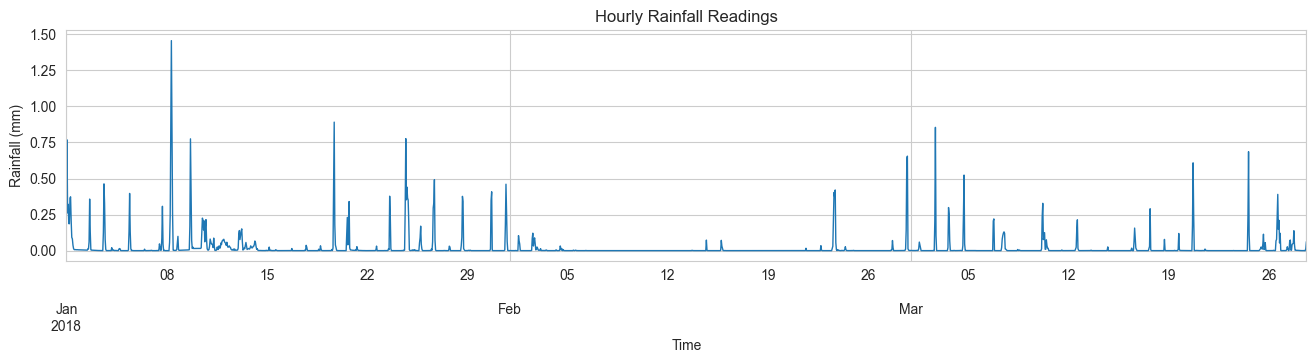

In [8]:
# Plot the downsampled hourly data
sns.set_style('whitegrid')
plt.figure(figsize=(16, 3))
df_hourly.groupby('timestamp')['reading_value'].mean().plot(kind='line', linewidth=1)
plt.ylabel('Rainfall (mm)')
plt.xlabel('Time')
plt.title("Hourly Rainfall Readings")
plt.show()

In [9]:
stations_meta[:15]

station_id  location_latitude  location_longitude  node_idx
0         S77            1.29370            103.8125         0
1        S109            1.37640            103.8492         1
2        S117            1.25600            103.6790         2
3         S55            1.38370            103.8860         3
4         S64            1.38240            103.7603         4
5         S90            1.31910            103.8191         5
6         S61            1.32300            103.9217         6
7        S114            1.38000            103.7300         7
8         S11            1.37460            103.6938         8
9         S50            1.33370            103.7768         9
10       S107            1.31350            103.9625        10
11       S118            1.29940            103.8461        11
12       S120            1.30874            103.8180        12
13        S33            1.30810            103.7100        13
14        S71            1.29230            103.7815        14

Display the geographic location of each station:

In [10]:
fig = px.scatter_map(
    stations_meta,
    lat='location_latitude',
    lon='location_longitude',
    hover_name='station_id',
    zoom=10,
    height=600,
)

fig.update_layout(title='Rainfall Stations Geographic Distribution')
fig.show()

## 2. Feature engineering  
1. Create edge indices (whether each node has a relationship with another; binary)  
2. Create edge features (edge attributes)  
3. Create node features  

In [11]:
# Pivot into a (T × N) array of readings
timestamps = sorted(df_hourly["timestamp"].unique())
N = len(stations_meta)
T = len(timestamps)

X = np.zeros((T, N), dtype=np.float32)
for ti, t in enumerate(timestamps):
    slice_ = df_hourly[df_hourly["timestamp"] == t]
    for _, row in slice_.iterrows():
        j = station_to_idx[row["station_id"]]
        X[ti, j] = row["reading_value"]

# Build graph connectivity and per-edge distances from station_meta
coords_rad = np.deg2rad(
    stations_meta[["location_latitude", "location_longitude"]].values
)
dist_mat = haversine_distances(coords_rad, coords_rad) * 6371.0  # km

# Threshold of 5km (exclude 0 to avoid self-loop)
threshold_km = 5
mask = (dist_mat < threshold_km) & (dist_mat > 0.0)
src, dst = np.where(mask)
edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_weight = torch.tensor(dist_mat[src, dst], dtype=torch.float)

# Prepare features and targets for forecasting
features = X[:-1, :, None]
targets = X[1: , :, None]

# Package into a StaticGraphTemporalSignal
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features,
    targets=targets
)

C:\Users\Terrence Yeoh\AppData\Local\Temp\ipykernel_4124\1416600801.py:23: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)



#### 2.1 Edge indices  
Edge indices indicate which nodes have a pair-wise relationship; in this case, we set the definition of a relationship as two nodes being within 5km distance of each other. The shape of the edge indices should be [2 x num_edges]; a single object in each row indicates a single node (`station_id`), and the object in the adjacent row indicates the node that it has a pair-wise relationship with.

In [12]:
# Display edge indices (10 examples)
print(edge_index.shape)
print(edge_index[0, 50:60])
print(edge_index[1, 50:60])

torch.Size([2, 258])
tensor([10, 10, 11, 11, 11, 11, 11, 11, 11, 11])
tensor([ 6, 34,  0,  5, 12, 18, 22, 30, 35, 37])


#### 2.2 Edge features  
The edge features in this case will be the distance calculated between nodes that have been determined to have a pair-wise relationship (<5km distance between each other). The size of this should be the same as the number of edges.

In [13]:
# Display edge features
print(edge_weight.shape)
edge_weight

torch.Size([258])


tensor([2.9181, 3.7886, 1.7806, 3.4497, 3.2602, 2.8451, 2.8633, 4.1705, 4.2597,
        4.6229, 3.7489, 4.9647, 4.6267, 2.5546, 4.1705, 4.8744, 3.3480, 3.7388,
        3.3788, 4.0752, 4.3397, 4.0841, 2.9181, 4.9746, 3.7158, 1.1585, 2.9548,
        2.1553, 2.6744, 2.8935, 4.1655, 4.2986, 4.6569, 4.2110, 2.2254, 3.8797,
        3.4155, 3.3788, 4.0686, 1.1546, 4.6219, 3.7608, 4.0686, 3.4721, 3.1894,
        3.4512, 4.9746, 4.6330, 2.3584, 3.8587, 4.6569, 3.9147, 3.7886, 3.7158,
        3.2919, 4.8896, 2.2863, 1.6359, 0.9956, 4.8204, 2.7654, 4.8333, 3.4553,
        1.7806, 1.1585, 3.2919, 4.4504, 4.0250, 2.0664, 3.7453, 2.3271, 4.2648,
        4.6324, 4.7331, 3.4497, 4.6330, 4.4504, 1.2060, 3.3052, 4.8744, 4.2110,
        4.4857, 4.9210, 3.6689, 4.4131, 3.9278, 2.4640, 3.8895, 2.7513, 3.8895,
        4.2597, 2.9548, 4.8896, 4.0250, 3.4587, 2.5346, 4.5896, 1.6506, 3.5060,
        4.4732, 3.6093, 3.2564, 4.0752, 4.1762, 4.1898, 4.7821, 4.4141, 2.2254,
        4.4857, 4.9064, 2.1942, 3.4721, 

#### 2.3 Node features  
Node features has the sahpe [S, N, F], where:  
**S**: Number of snapshots/timesteps  
**N**: Number of nodes (unique `station_id`)  
**F**: Number of node features (`reading_value`; only 1 since this is univariate)

In [14]:
# Display node features
print("Shape of node features:", dataset.features.shape)
dataset.features

Shape of node features: (2079, 54, 1)


array([[[0.53333336],
        [0.5       ],
        [2.2       ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.4833333 ],
        [1.9333333 ],
        [0.35      ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.26666668],
        [0.28333333],
        [0.5       ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]], shape=(2079, 54, 1), dtype=float32)

#### 2.4 Viewing edge data  
Just for visualising, we can convert the edge data from tensors/array to dataframes.

In [15]:
# 1. Full pairwise distance DataFrame (including self with distance 0)
station_ids = stations_meta["station_id"].tolist()
dist_df = pd.DataFrame(
    dist_mat,
    index=station_ids,
    columns=station_ids
)

# name the index so reset_index produces the right column
dist_df = dist_df.rename_axis("station_id_1").reset_index()

# melt into long form
dist_df = dist_df.melt(
    id_vars="station_id_1",
    var_name="station_id_2",
    value_name="distance_km"
)
dist_df = dist_df[dist_df["station_id_1"] != dist_df["station_id_2"]]

# Apply the same 5 km threshold used for edges
threshold_km = 5.0
edge_df = dist_df[dist_df["distance_km"] < threshold_km].copy()

In [16]:
# Dataframe of all pairwise distances
dist_df[:15]

station_id_1 station_id_2  distance_km
1          S109          S77    10.060191
2          S117          S77    15.421545
3           S55          S77    12.919348
4           S64          S77    11.443381
5           S90          S77     2.918093
6           S61          S77    12.568919
7          S114          S77    13.273821
8           S11          S77    15.969875
9           S50          S77     5.960940
10         S107          S77    16.819641
11         S118          S77     3.788586
12         S120          S77     1.780633
13          S33          S77    11.506496
14          S71          S77     3.449679
15          S43          S77     9.821436

In [17]:
# Dataframe of edges with distance below threshold (5 km)
edge_df[:15]

station_id_1 station_id_2  distance_km
5            S90          S77     2.918093
11          S118          S77     3.788586
12          S120          S77     1.780633
14           S71          S77     3.449679
30          S111          S77     3.260164
35           S79          S77     2.845086
36           S92          S77     2.863309
57           S55         S109     4.170543
72           S07         S109     4.259665
85          S900         S109     4.622870
91           S88         S109     3.748918
97           S69         S109     4.964674
98           S36         S109     4.626748
99           S08         S109     2.554628
163         S109          S55     4.170543

## 3. Converting to static temporal graph dataset  

In [ ]:
# `stations_meta` has columns ['station_id','location_latitude','location_longitude','node_idx']
station_to_idx = dict(zip(stations_meta['station_id'], stations_meta['node_idx']))

# Build the graph edges + distances as edge features (edge_attr)
coords_rad = np.deg2rad(
    stations_meta[['location_latitude','location_longitude']].values
)
dist_mat = haversine_distances(coords_rad, coords_rad) * 6371.0  # km

# Threshold of 5km (exclude 0 to avoid self-loop)
threshold_km = 5
mask = (dist_mat < threshold_km) & (dist_mat > 0.0)
src, dst = np.where(mask)
edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_weight = torch.tensor(dist_mat[src, dst], dtype=torch.float)

# Pivot df_hourly into a wide (T × N) matrix of readings
timestamps = sorted(df_hourly['timestamp'].unique())
N = stations_meta.shape[0]
T = len(timestamps)

X = np.zeros((T, N), dtype=np.float32)
for ti, t in enumerate(timestamps):
    slice_ = df_hourly[df_hourly['timestamp'] == t]
    for _, row in slice_.iterrows():
        j = station_to_idx[row['station_id']]
        X[ti, j] = row['reading_value']

# Build features/targets for next-hour forecasting
# features[t] → values at time t, targets[t] → values at t+1
features = X[:-1, :, None]  # shape (T-1, N, 1)
targets = X[1: , :, None]  # shape (T-1, N, 1)

# Compute an 80/20 split index on the time axis
num_snapshots = features.shape[0]
split_idx = int(num_snapshots * 0.8)

train_idx = list(range(split_idx))
test_idx = list(range(split_idx, num_snapshots))

# Flatten all training‐period readings into a (num_train_snapshots * N, 1) array
train_feats = features[train_idx, :, 0].reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(train_feats)
# Scale both train and test
features_scaled = scaler.transform(
    features.reshape(-1, 1)
).reshape(features.shape)   # back to (S, N, 1)
targets_scaled = scaler.transform(
    targets.reshape(-1, 1)
).reshape(targets.shape)     # back to (S, N, 1)

# Create train and test StaticGraphTemporalSignal datasets
train_dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features_scaled[train_idx],
    targets=targets_scaled[train_idx]
)
test_dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=features_scaled[test_idx],
    targets=targets_scaled[test_idx]
)
# Set snapshot count to be retrieved for batching
train_dataset._set_snapshot_count()
test_dataset._set_snapshot_count()

We can examine the components of the `StaticGraphTemporalSignal` dataset by looking at a single snapshot (time step 0):

In [71]:
# Visualising the dataset at snapshot 0 (first timestep)
train_dataset[0]

Data(x=[54, 1], edge_index=[2, 258], edge_attr=[258], y=[54, 1])

**Breaking down the dataset components:**  
`x` -> Node features; shape [N, F]  
`edge_index` -> Number of edges (how many pair-wise relationships exist between all nodes); shape [2, E]  
`edge_attr` -> Edge features; shape [E]  
`y` -> Labels; shape [N, 1]  

Notation legend:  
**N** = total number of nodes (unique `station_id` values)  
**F** = total number of node features (univariate so 1)  
**E** = total number of edges  
**S** = total number of snapshots (or time steps)

## 4. Visualising the dataset in graphical format  
It is difficult to imagine how the graph data looks just by seeing them in arrays and observing the array dimensions. To understand the spatial dimension, we can plot out the graph.  

#### 4.1 Spatial graph visualisation  
To start, we can plot the nodes and edges spatially using the NetworkX package: 

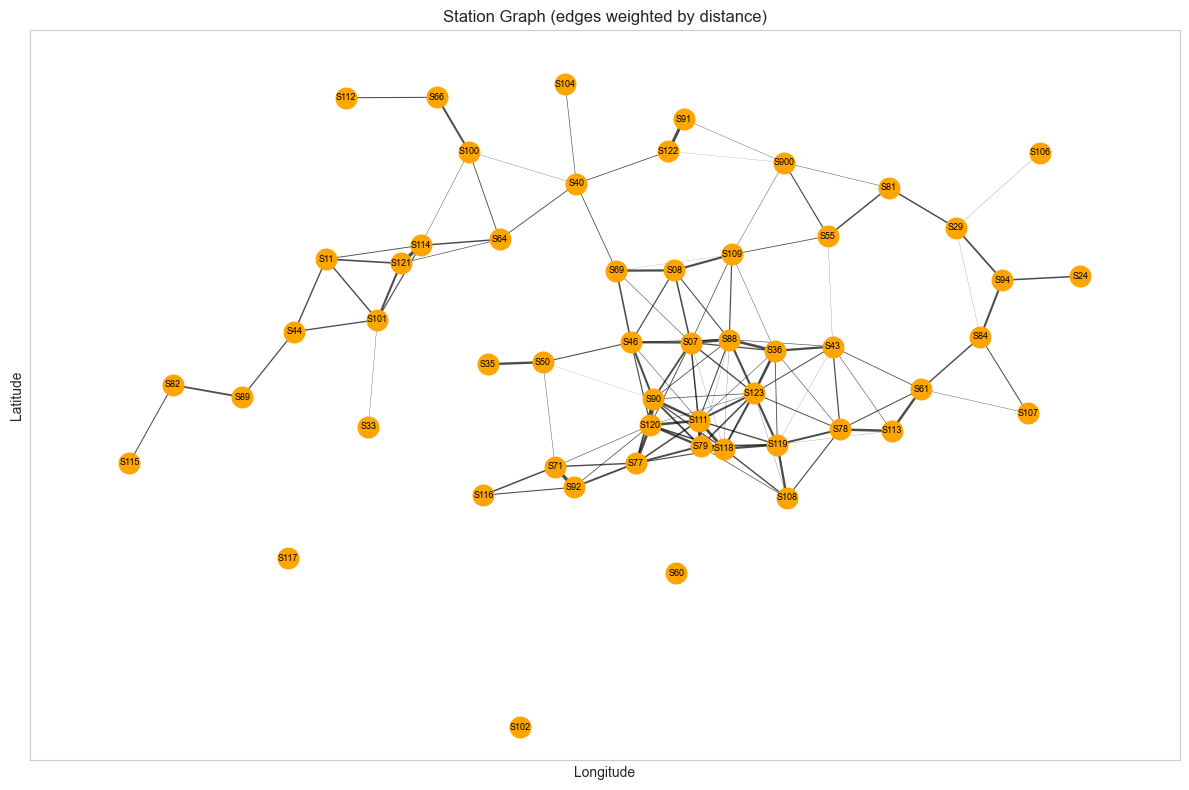

In [19]:
# Build NetworkX graph
G = nx.Graph()
# Add nodes with lat/lon as position attribute
for _, row in stations_meta.iterrows():
    G.add_node(
        int(row["node_idx"]),
        station_id=row["station_id"],
        pos=(row["location_longitude"], row["location_latitude"])  # lon, lat for natural map orientation
    )

# Add edges with distance as weight
src = edge_index[0].cpu().numpy()
dst = edge_index[1].cpu().numpy()
dists = edge_weight.cpu().numpy()

for u, v, d in zip(src, dst, dists):
    # Optionally skip self-loops if any
    if u == v:
        continue
    G.add_edge(u, v, weight=d)

# Extract positions
pos = {n: G.nodes[n]['pos'] for n in G.nodes()}

# Draw
plt.figure(figsize=(12, 8))
# Edge widths scaled inverse to distance (closer = thicker), or direct if you prefer
weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
# Normalize for plotting
max_w = weights.max()
edge_widths = (1 - (weights / max_w)) * 3 + 0.1  # closer edges thicker

nx.draw_networkx_nodes(G, pos, node_size=220, node_color="orange")
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)
# Optional: label a few nodes
nx.draw_networkx_labels(G, pos, {n: G.nodes[n]['station_id'] for n in G.nodes()}, font_size=6.5)

plt.title("Station Graph (edges weighted by distance)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(False)
plt.tight_layout()
plt.show()

#### 4.2 Geographic graph visualisation  
To translate it to the real world, we can overlay the same plot geographically on a map of Singapore:

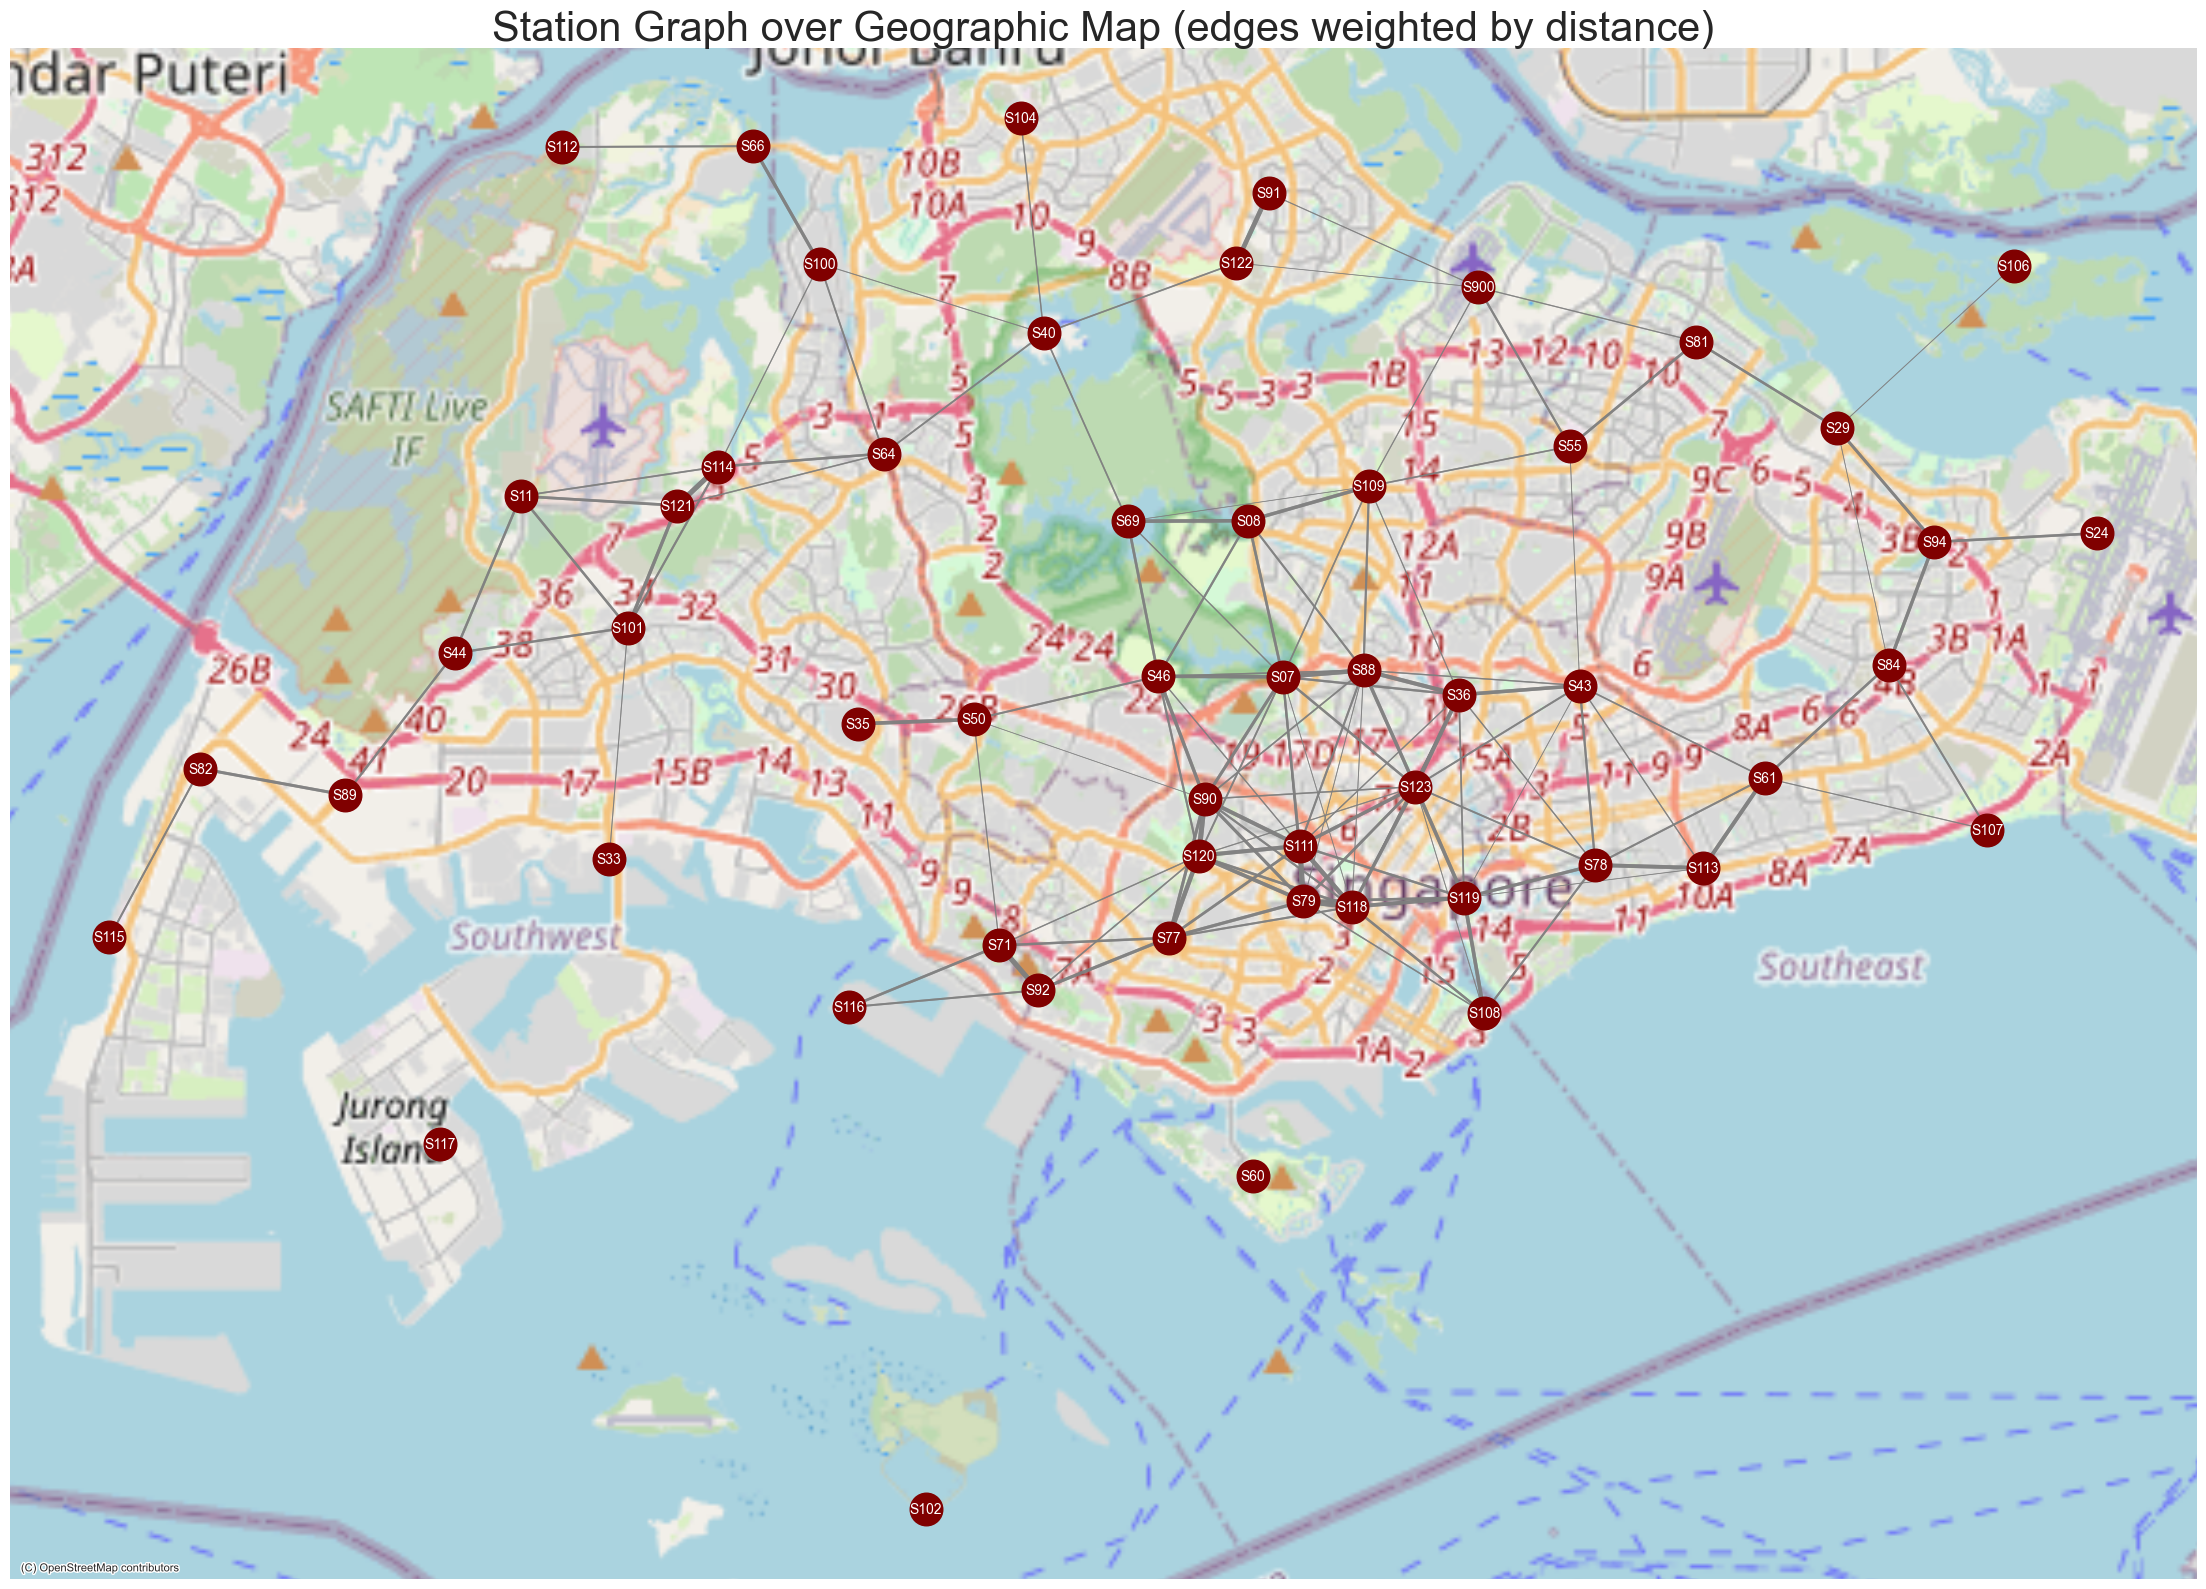

In [ ]:
# Build GeoDataFrame of nodes
gdf_nodes = gpd.GeoDataFrame(
    stations_meta,
    geometry=gpd.points_from_xy(
        stations_meta["location_longitude"],
        stations_meta["location_latitude"]
    ),
    crs="EPSG:4326"  # WGS84 lon/lat
)

# Build edges as LineStrings with distance attribute
src = edge_index[0].cpu().numpy()
dst = edge_index[1].cpu().numpy()
dists = edge_weight.cpu().numpy()

edge_rows = []
for u, v, d in zip(src, dst, dists):
    if u == v:
        continue  # skip self-loop
    pt_u = gdf_nodes.loc[gdf_nodes["node_idx"] == u, "geometry"].values[0]
    pt_v = gdf_nodes.loc[gdf_nodes["node_idx"] == v, "geometry"].values[0]
    line = LineString([pt_u, pt_v])
    edge_rows.append({"u": int(u), "v": int(v), "distance_km": float(d), "geometry": line})

gdf_edges = gpd.GeoDataFrame(edge_rows, crs="EPSG:4326")

# Reproject to Web Mercator for contextily basemap
gdf_nodes_web = gdf_nodes.to_crs("EPSG:3857")
gdf_edges_web = gdf_edges.to_crs("EPSG:3857")

# Normalize edge widths (closer = thicker)
weights = gdf_edges_web["distance_km"].to_numpy()
# invert and scale for visibility: small distance → larger width
edge_widths = (1 - (weights / weights.max())) * 4 + 0.5

# Plot
fig, ax = plt.subplots(figsize=(24, 16))
# Plot edges
gdf_edges_web.plot(
    ax=ax,
    linewidth=edge_widths,
    alpha=0.8,
    edgecolor="tab:gray"
)
# Plot nodes
gdf_nodes_web.plot(ax=ax, color="maroon", markersize=550, zorder=3)

# Annotate station IDs
for idx, row in gdf_nodes_web.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        str(row["station_id"]),
        fontsize=10,
        ha="center",
        va="center",
        color='white'
    )

# Add base map
source = ctx.providers.OpenStreetMap.Mapnik
# one_map = TileProvider(
#     name="OneMapSG.Default",
#     url="https://maps-a.onemap.sg/v3/Default/{z}/{x}/{y}.png",
#     attribution="© Singapore Land Authority (SLA)",
#     max_zoom=19,  # adjust if needed
#     tile_size=256,
# )
ctx.add_basemap(ax, source=source)

ax.set_axis_off()
ax.set_title("Station Graph over Geographic Map (edges weighted by distance)", fontsize=30)
plt.tight_layout()
plt.show()

#### 4.3 Individual graph snapshots  
Every time step has its own graph snapshot where the node value (rainfall reading value for the station) changes. We can visualise the rainfall data for individual snapshots as well:

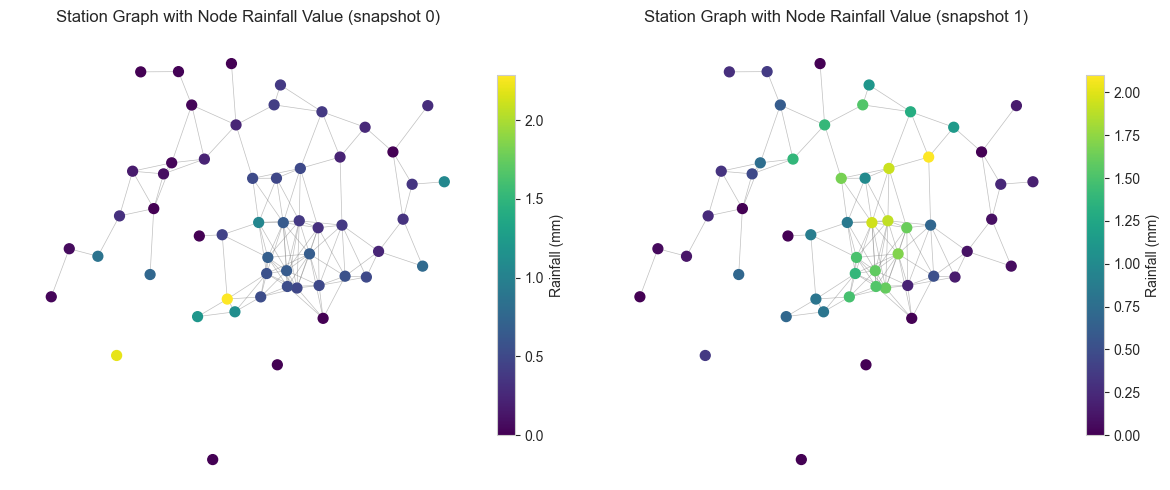

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import networkx as nx

def plot_station_snapshots(
    snapshots,
    features,
    G: nx.Graph,
    pos: dict,
    cmap="viridis",
    node_size=100,
    edge_kwargs=None,
    title_prefix="Station Graph with Node Rainfall Value",
):
    """
    snapshots: int or list of ints, time-step indices to visualize (indexes into features)
    features: array-like of shape (S, N, F) where F>=1; uses the first feature channel
    G: networkx graph (nodes must match order implied by features' second dim)
    pos: dict of node positions for drawing (e.g., {node_idx: (x,y), ...})
    edge_kwargs: optional dict of kwargs passed to nx.draw_networkx_edges
    """
    if isinstance(snapshots, int):
        snapshots = [snapshots]
    S, N, F = features.shape
    assert F >= 1, "features must have at least one channel"
    num = len(snapshots)
    # Layout subplots
    cols = min(3, num)
    rows = (num + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), squeeze=False)
    edge_kwargs = edge_kwargs or {"width": 0.5, "alpha": 0.5, "edge_color": "gray"}

    for idx, snap in enumerate(snapshots):
        ax = axes[idx // cols][idx % cols]
        node_vals = features[snap, :, 0]
        vmin = np.nanmin(node_vals)
        vmax = np.nanmax(node_vals)

        # draw edges first
        nx.draw_networkx_edges(G, pos, ax=ax, **edge_kwargs)
        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_size=node_size,
            node_color=node_vals,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_title(f"{title_prefix} (snapshot {snap})")
        ax.set_axis_off()
        cbar = fig.colorbar(nodes, ax=ax, shrink=0.8, pad=0.02)
        cbar.set_label(f"Rainfall (mm)")

    # Hide any unused subplots
    total_plots = rows * cols
    for extra in range(num, total_plots):
        ax = axes[extra // cols][extra % cols]
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_station_snapshots([0, 1], features, G, pos, node_size=50)

## 5. Spatio-Temporal GNN instantiation  
`torch_geometric_temporal.nn.recurrent.GConvGRU()` -> Graph Convolutional Network with a GRU

### 5.1 Single GConvGRU Layer Model

#### Build the model:

In [268]:
class STGNN(nn.Module):
    def __init__(self, in_ch=1, hidden=32, K=2, out_ch=1):
        super().__init__()
        self.cell = GConvGRU(in_channels=in_ch, out_channels=hidden, K=K)
        self.head = nn.Linear(hidden, out_ch)

    def forward_step(self, batch_x, edge_index, edge_attr, h):
        # one recurrent step; batch_x is (B*N, F)
        h = self.cell(batch_x, edge_index, edge_attr, h)
        y = self.head(h)                                  
        return y, h
    
# Display model structure
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STGNN(in_ch=1, hidden=32, K=3, out_ch=1).to(device)
print("Model structure:\n")
print(model)

Model structure:

STGNN(
  (cell): GConvGRU(
    (conv_x_z): ChebConv(1, 32, K=3, normalization=sym)
    (conv_h_z): ChebConv(32, 32, K=3, normalization=sym)
    (conv_x_r): ChebConv(1, 32, K=3, normalization=sym)
    (conv_h_r): ChebConv(32, 32, K=3, normalization=sym)
    (conv_x_h): ChebConv(1, 32, K=3, normalization=sym)
    (conv_h_h): ChebConv(32, 32, K=3, normalization=sym)
  )
  (head): Linear(in_features=32, out_features=1, bias=True)
)


#### Create helper functions:

In [269]:
def build_snapshot_batch(time_indices, features_scaled, targets_scaled, edge_index, edge_weight):
    """Build a PyG Batch for one time step from B different starts."""
    graphs = []
    for t in time_indices:
        x_t = torch.from_numpy(features_scaled[t]).float()   # (N, F)
        y_t = torch.from_numpy(targets_scaled[t]).float()    # (N, 1) -> next step
        graphs.append(Data(x=x_t, y=y_t, edge_index=edge_index, edge_attr=edge_weight))
    return Batch.from_data_list(graphs)

def make_windows_from_range(start_idx, end_idx_inclusive, seq_len):
    """Valid window starts s where [s, s+seq_len-1] is inside [start_idx, end_idx_inclusive]."""
    return list(range(start_idx, end_idx_inclusive - seq_len + 1))

def window_loader(windows, batch_size, shuffle=True):
    """Yield lists of window starts (size ≤ batch_size)."""
    order = torch.randperm(len(windows)) if shuffle else torch.arange(len(windows))
    for i in range(0, len(windows), batch_size):
        yield [windows[j.item()] for j in order[i:i+batch_size]]

def inverse_scale_1d(arr_1d, scaler):
    return scaler.inverse_transform(arr_1d.reshape(-1,1)).reshape(-1)

def compute_metrics_unscaled(y_true_list, y_pred_list, scaler):
    """Aggregate over all steps; return dict with mse, rmse, r2 in original units."""
    y_true = torch.cat(y_true_list, dim=0).detach().cpu().numpy().reshape(-1)
    y_pred = torch.cat(y_pred_list, dim=0).detach().cpu().numpy().reshape(-1)
    y_true = inverse_scale_1d(y_true, scaler)
    y_pred = inverse_scale_1d(y_pred, scaler)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {"mse": mse, "rmse": rmse, "r2": r2, "mae": mae}

@torch.no_grad()
def evaluate_epoch(model, edge_index, edge_attr, features_scaled, targets_scaled,
                   windows, batch_size, seq_len, scaler, device, shuffle=False):
    """Validation/test pass. Returns (mean_scaled_loss, metrics_unscaled)."""
    model.eval()
    total_loss, n_win = 0.0, 0
    all_true, all_pred = [], []
    for starts in window_loader(windows, batch_size, shuffle=shuffle):
        h = None
        for s in range(seq_len):
            t_list = [s0 + s for s0 in starts]
            batch = build_snapshot_batch(t_list, features_scaled, targets_scaled, edge_index, edge_attr).to(device)
            y_hat, h = model.forward_step(batch.x, batch.edge_index, batch.edge_attr, h)
            total_loss += float(F.mse_loss(y_hat, batch.y).item())
            all_true.append(batch.y)
            all_pred.append(y_hat)
        n_win += 1
    mean_loss = total_loss / max(n_win, 1)
    metrics = compute_metrics_unscaled(all_true, all_pred, scaler)
    return mean_loss, metrics

@torch.no_grad()
def rollout_test_predictions(model, edge_index, edge_attr,
                             features_scaled, targets_scaled,
                             test_idx_ordered, scaler, device):
    """
    Sequential one-step-ahead rollout over the test range (no duplicates).
    Returns:
        y_true_orig:  (T_test, N)  in original units
        y_pred_orig:  (T_test, N)  in original units
    Note: each index t corresponds to predicting X[t+1] from X[t].
    """
    model.eval()
    h = None
    y_true_steps, y_pred_steps = [], []
    for t in test_idx_ordered:
        batch = build_snapshot_batch([t], features_scaled, targets_scaled, edge_index, edge_attr).to(device)
        y_hat, h = model.forward_step(batch.x, batch.edge_index, batch.edge_attr, h)
        y_true_steps.append(batch.y.squeeze(0))
        y_pred_steps.append(y_hat.squeeze(0))

    y_true = torch.stack(y_true_steps, dim=0).cpu().numpy().reshape(len(test_idx_ordered), -1)
    y_pred = torch.stack(y_pred_steps, dim=0).cpu().numpy().reshape(len(test_idx_ordered), -1)

    # inverse scale per vectorized flatten then reshape back
    y_true_orig = inverse_scale_1d(y_true.reshape(-1), scaler).reshape(y_true.shape)
    y_pred_orig = inverse_scale_1d(y_pred.reshape(-1), scaler).reshape(y_pred.shape)
    return y_true_orig, y_pred_orig

#### Training, validation and testing code:

In [270]:
# Prepare train-val-test splits
num_train = len(train_idx)
val_len = int(0.1 * num_train)
train_core_idx = train_idx[:num_train - val_len]
val_idx = train_idx[num_train - val_len:]

# Define start and end indices of each dataset split
train_start, train_end = train_core_idx[0], train_core_idx[-1]
val_start, val_end = val_idx[0], val_idx[-1]
test_start, test_end = test_idx[0], test_idx[-1]

# Hyperparameters
seq_len = 24 # lookback
batch_size = 32
epochs = 40
lr = 5e-5
weight_decay = 1e-4

# Static graph tensors on device 
edge_index = train_dataset.edge_index.to(device)
edge_attr  = train_dataset.edge_weight.to(device)

# Windows for each split 
train_windows = make_windows_from_range(train_start, train_end, seq_len)
val_windows = make_windows_from_range(val_start, val_end, seq_len)
test_windows = make_windows_from_range(test_start, test_end, seq_len)

# Model and optimiser
model = torch.compile(model)
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Numpy views for convenience
features_np = features_scaled
targets_np = targets_scaled

# Caching metrics
history = {
    "train_loss": [],
    "val_loss": [],
    "val_r2": [],
    "val_mae": [],
    "val_rmse": []
}

# Training loop with validation
for epoch in range(1, epochs + 1):
    model.train()
    total_train_loss, n_train = 0.0, 0

    for starts in window_loader(train_windows, batch_size, shuffle=True):
        h = None
        optim.zero_grad()
        loss_window = 0.0

        for s in range(seq_len):
            t_list = [s0 + s for s0 in starts]
            batch = build_snapshot_batch(t_list, features_np, targets_np, edge_index, edge_attr).to(device)
            y_hat, h = model.forward_step(batch.x, batch.edge_index, batch.edge_attr, h)
            loss_window = loss_window + F.mse_loss(y_hat, batch.y)

        # Normalise window loss by seq_len
        loss_window = loss_window / seq_len
        loss_window.backward()
        optim.step()
        total_train_loss += float(loss_window.item())
        n_train += 1

    train_loss_mean = total_train_loss / max(n_train, 1)

    # Validation
    val_loss_mean, val_metrics = evaluate_epoch(
        model, edge_index, edge_attr, features_np, targets_np,
        val_windows, batch_size, seq_len, scaler, device, shuffle=False
    )
    val_loss_mean = val_loss_mean / seq_len

    # Cache metrics for plotting
    history["train_loss"].append(train_loss_mean)
    history["val_loss"].append(val_loss_mean)
    history["val_r2"].append(val_metrics["r2"])
    history["val_mae"].append(val_metrics["mae"])
    history["val_rmse"].append(val_metrics["rmse"])

    print(f"Epoch {epoch:03d} | "
          f"Train Loss {train_loss_mean:.4f} | "
          f"Val Loss {val_loss_mean:.4f} | "
          f"Val R-squared {val_metrics['r2']:.4f} | "
          f"Val MAE {val_metrics['mae']:.4f} | "
          f"Val RMSE {val_metrics['rmse']:.4f}")

# Final test metrics (batched)
test_loss_mean, test_metrics = evaluate_epoch(
    model, edge_index, edge_attr, features_np, targets_np,
    test_windows, batch_size, seq_len, scaler, device, shuffle=False
)
test_loss_mean = test_loss_mean / seq_len
print("\n=== Test Metrics (original units) ===")
print(f"Test Loss: {test_loss_mean:.6f} | "
      f"Test R-squared : {test_metrics['r2']:.6f} | "
      f"Test MAE : {test_metrics['mae']:.6f} | "
      f"Test RMSE: {test_metrics['rmse']:.6f}")

Epoch 001 | Train Loss 0.9690 | Val Loss 0.7392 | Val R-squared -0.0160 | Val MAE 0.0267 | Val RMSE 0.1343
Epoch 002 | Train Loss 0.9716 | Val Loss 0.7345 | Val R-squared -0.0103 | Val MAE 0.0273 | Val RMSE 0.1339
Epoch 003 | Train Loss 0.9535 | Val Loss 0.7304 | Val R-squared -0.0050 | Val MAE 0.0270 | Val RMSE 0.1336
Epoch 004 | Train Loss 0.9453 | Val Loss 0.7266 | Val R-squared -0.0002 | Val MAE 0.0274 | Val RMSE 0.1333
Epoch 005 | Train Loss 0.9382 | Val Loss 0.7234 | Val R-squared 0.0038 | Val MAE 0.0283 | Val RMSE 0.1330
Epoch 006 | Train Loss 0.9321 | Val Loss 0.7200 | Val R-squared 0.0082 | Val MAE 0.0273 | Val RMSE 0.1327
Epoch 007 | Train Loss 0.9284 | Val Loss 0.7172 | Val R-squared 0.0119 | Val MAE 0.0278 | Val RMSE 0.1324
Epoch 008 | Train Loss 0.9211 | Val Loss 0.7143 | Val R-squared 0.0157 | Val MAE 0.0277 | Val RMSE 0.1322
Epoch 009 | Train Loss 0.9157 | Val Loss 0.7117 | Val R-squared 0.0189 | Val MAE 0.0286 | Val RMSE 0.1320
Epoch 010 | Train Loss 0.9105 | Val Loss 0

#### Plot train vs. validation loss:

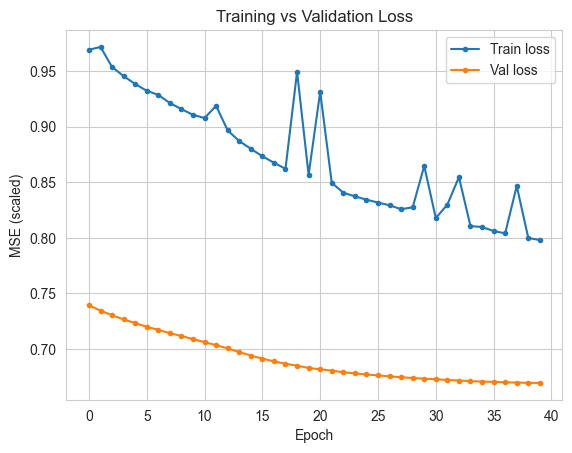

In [271]:
plt.figure()
plt.plot(history["train_loss"], marker='.', label="Train loss")
plt.plot(history["val_loss"], marker='.', label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled)")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

Clearly there is room for tuning and adding early stopping, as the training loss displays a lot of fluctuation.

#### Plot forecast plot for single and all stations:

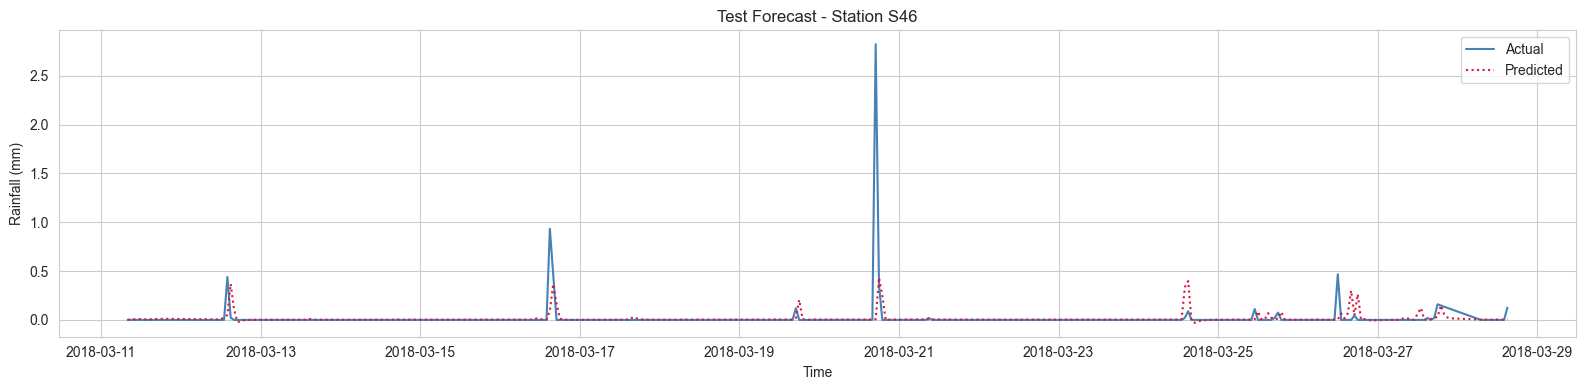

In [272]:
# Compile test predictions
test_idx_ordered = list(range(test_start, test_end + 1))
y_true_test, y_pred_test = rollout_test_predictions(
    model, edge_index, edge_attr, features_np, targets_np, test_idx_ordered, scaler, device
)

# For plotting against timestamps
test_plot_timestamps = [timestamps[t+1] for t in test_idx_ordered]

# Select station for plotting
i = 33
plt.figure(figsize=(16, 4))
plt.plot(test_plot_timestamps, y_true_test[:, i], label="Actual", color='steelblue')
plt.plot(test_plot_timestamps, y_pred_test[:, i], label="Predicted", color='crimson', ls=':')
plt.xlabel("Time")
plt.ylabel("Rainfall (mm)")
plt.title(f"Test Forecast - Station {stations_meta['station_id'][i]}")
plt.legend()
plt.tight_layout()
plt.show()

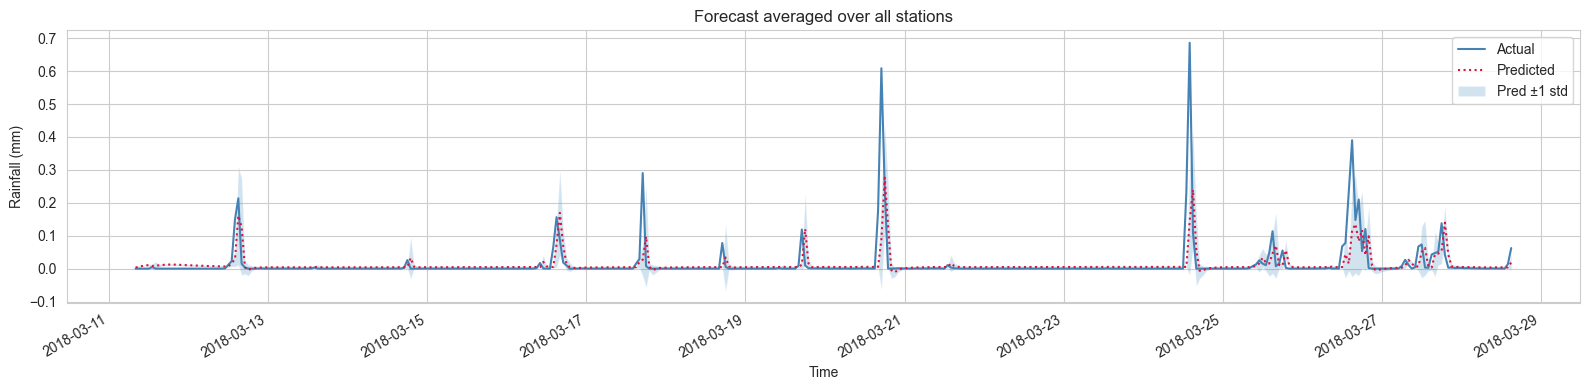

In [274]:
# Plot overall forecast averaged over all nodes

# Average over nodes
true_mean = y_true_test.mean(axis=1)
pred_mean = y_pred_test.mean(axis=1)

# Display standard deviation across nodes
pred_std = y_pred_test.std(axis=1)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(test_plot_timestamps, true_mean, label="Actual", color='steelblue')
ax.plot(test_plot_timestamps, pred_mean, label="Predicted", color='crimson', ls=':')

# Plot ±1 standard deviation
ax.fill_between(test_plot_timestamps,
                pred_mean - pred_std, pred_mean + pred_std,
                alpha=0.2, label="Pred ±1 std")

ax.set_title("Forecast averaged over all stations")
ax.set_xlabel("Time")
ax.set_ylabel("Rainfall (mm)")
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 6. Model Explanations with SHAP

100%|██████████| 1/1 [01:39<00:00, 99.15s/it]


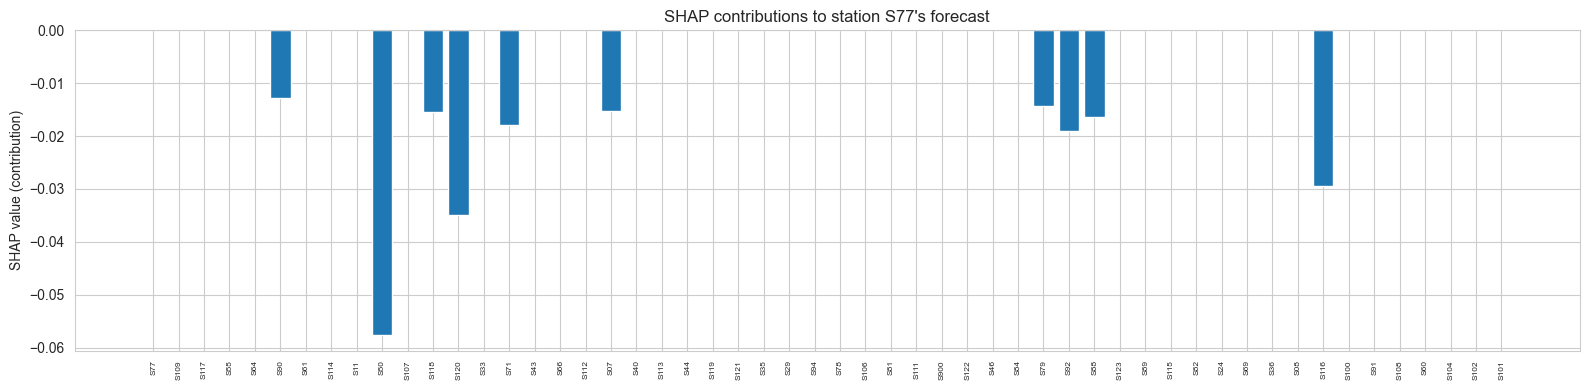

In [286]:
# Choose one snapshot to explain, and one target station
snapshot_to_explain = train_idx[-1]
target_station_idx = 0 

# Helper to get model prediction given a snapshot's feature matrix x: shape (N, F)
def model_predict_flat(x_np, edge_index, edge_weight):
    """
    x_np: numpy array shape (N, F) for one snapshot
    Returns: numpy vector of shape (N,) of predicted next-step rainfall
    """
    x_tensor = torch.from_numpy(x_np).to(device).float()
    with torch.no_grad():
        # Reset hidden state to None for local explanation (approximate)
        y_hat, H = model.forward_step(x_tensor, edge_index.to(device), edge_weight.to(device), None)
        out = y_hat.squeeze(-1).cpu().numpy()
    return out

# Build wrapper for shap: it expects function taking 2D array (samples × features)
def shap_wrapper(flat_X):
    results = []
    ei = dataset.edge_index  # static
    ew = dataset.edge_weight
    for row in flat_X:
        x_snapshot = row.reshape(features.shape[1], features.shape[2])
        preds = model_predict_flat(x_snapshot, ei, ew)
        results.append(preds[target_station_idx])
    return np.array(results)

# Prepare background (use a small subset of training snapshots)
bg_snaps = train_idx[:50]
bg_features = []
for t in bg_snaps:
    snap = dataset[t]
    x = snap.x.cpu().numpy()
    bg_features.append(x.flatten())
bg_features = np.stack(bg_features, axis=0)

# Snapshot to explain
snap = dataset[snapshot_to_explain]
x_explain = snap.x.cpu().numpy().flatten()[None, :]

# Create SHAP KernelExplainer
explainer = shap.KernelExplainer(shap_wrapper, bg_features)

# Compute SHAP values for the target snapshot
shap_vals = explainer.shap_values(x_explain, nsamples=200)
shap_vals = shap_vals[0].reshape(features.shape[1], features.shape[2])

# For univariate features (F=1), we can plot contribution from each node
station_ids = stations_meta['station_id'].tolist()
contribs = shap_vals[:, 0]
plt.figure(figsize=(16, 4))
plt.bar(range(len(station_ids)), contribs)
plt.xticks(range(len(station_ids)), station_ids, rotation=90, fontsize=6)
plt.ylabel("SHAP value (contribution)")
plt.title(f"SHAP contributions to station {station_ids[target_station_idx]}'s forecast")
plt.tight_layout()
plt.show()